In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [15]:
# Load the dataset
data = pd.read_csv('lung_cancer.csv')

In [16]:
# Drop unnecessary columns
data = data.drop(['index', 'Patient Id'], axis=1)

In [17]:
# Encode categorical variables
label_encoders = {}
for column in ['Gender', 'Level']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [18]:
# Separate features and labels
X = data.drop('Level', axis=1).values.astype(np.float32)
y = data['Level'].values

In [19]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [20]:
# Create PyTorch datasets
class LungCancerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features)
        self.labels = torch.tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = LungCancerDataset(X_train, y_train)
test_dataset = LungCancerDataset(X_test, y_test)

In [21]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
# Define the neural network with Dropout
class LungCancerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LungCancerModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

input_size = X.shape[1]
num_classes = len(np.unique(y))
model = LungCancerModel(input_size, num_classes)

In [23]:
# Define loss and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-5)

In [24]:
# Implement early stopping
epochs = 100
best_accuracy = 0
patience = 5
trigger_times = 0

for epoch in range(epochs):
    model.train()
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [25]:
for epoch in range(epochs):
    model.train()
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_features = torch.tensor(X_test)
        val_labels = torch.tensor(y_test).long()
        val_outputs = model(val_features)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_accuracy = accuracy_score(
            val_labels.numpy(), val_predicted.numpy())

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_lung_cancer_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping at epoch:', epoch+1)
            break

Epoch [1/100], Loss: 0.0376, Validation Accuracy: 1.0000
Epoch [2/100], Loss: 0.1696, Validation Accuracy: 1.0000
Epoch [3/100], Loss: 0.0824, Validation Accuracy: 1.0000
Epoch [4/100], Loss: 0.1516, Validation Accuracy: 1.0000
Epoch [5/100], Loss: 0.1316, Validation Accuracy: 1.0000
Epoch [6/100], Loss: 0.1457, Validation Accuracy: 1.0000
Early stopping at epoch: 6


In [13]:
# Save the model
torch.save(model.state_dict(), 'LCmodel.pth')

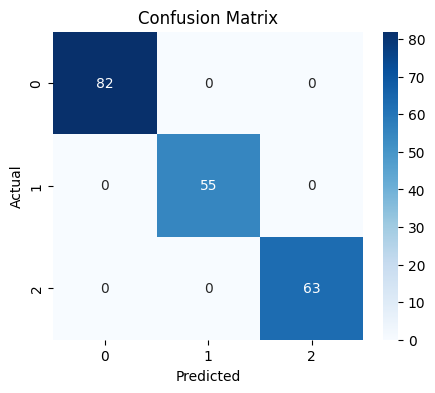

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Generate predictions for the test set
model.eval()
with torch.no_grad():
    val_features = torch.tensor(X_test)
    val_labels = torch.tensor(y_test).long()
    val_outputs = model(val_features)
    _, val_predicted = torch.max(val_outputs.data, 1)

# Compute the confusion matrix
cm = confusion_matrix(val_labels.numpy(), val_predicted.numpy())

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()